SNR:  3.850713843296499
Mean Squared Error:  0.042312810324285965


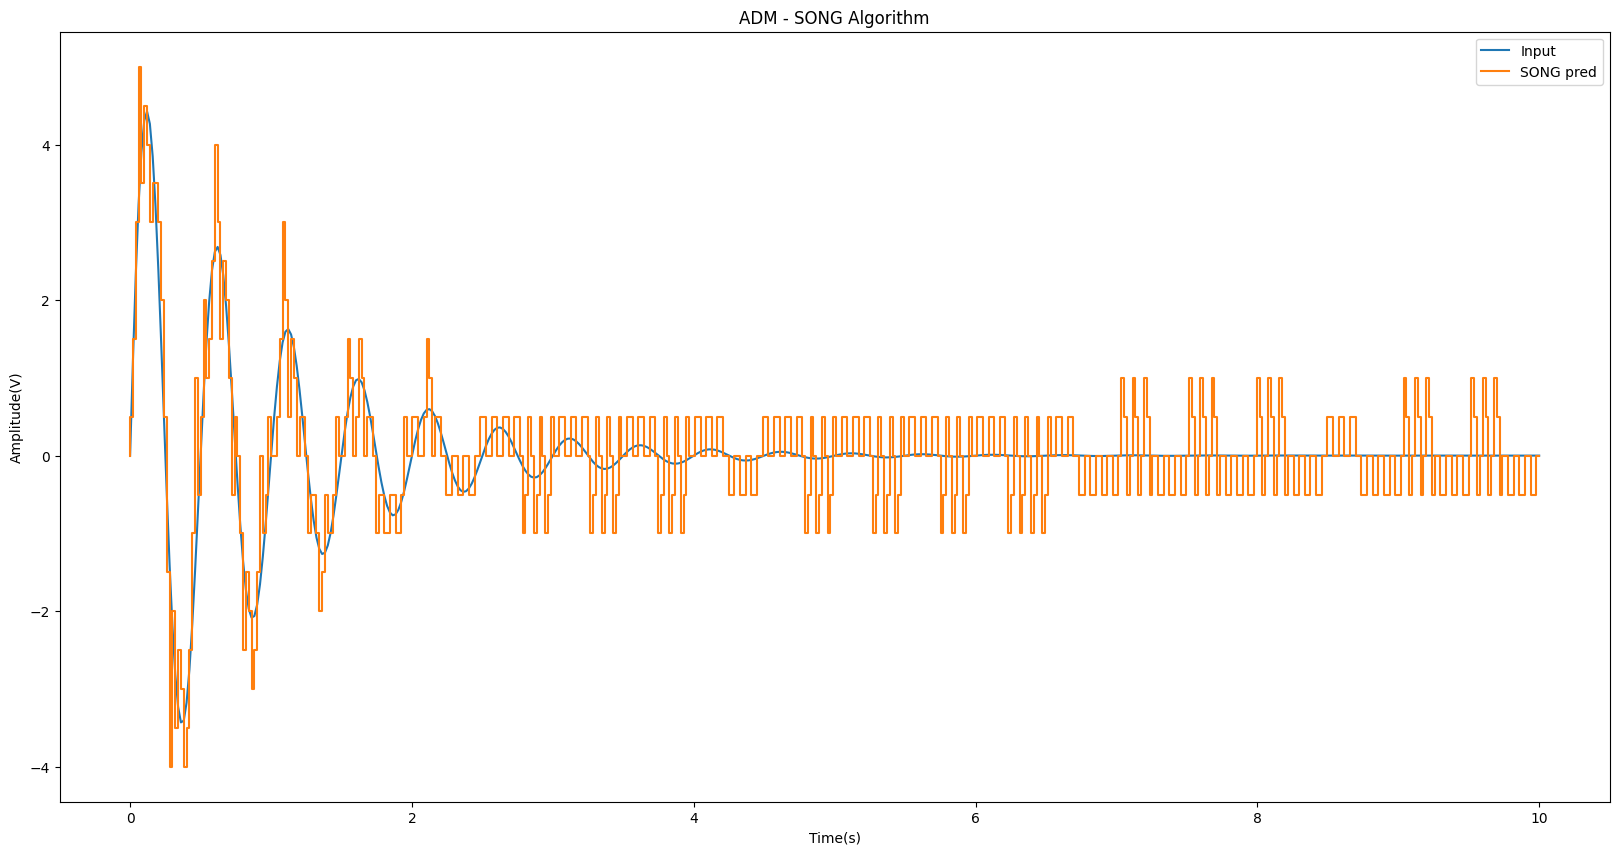

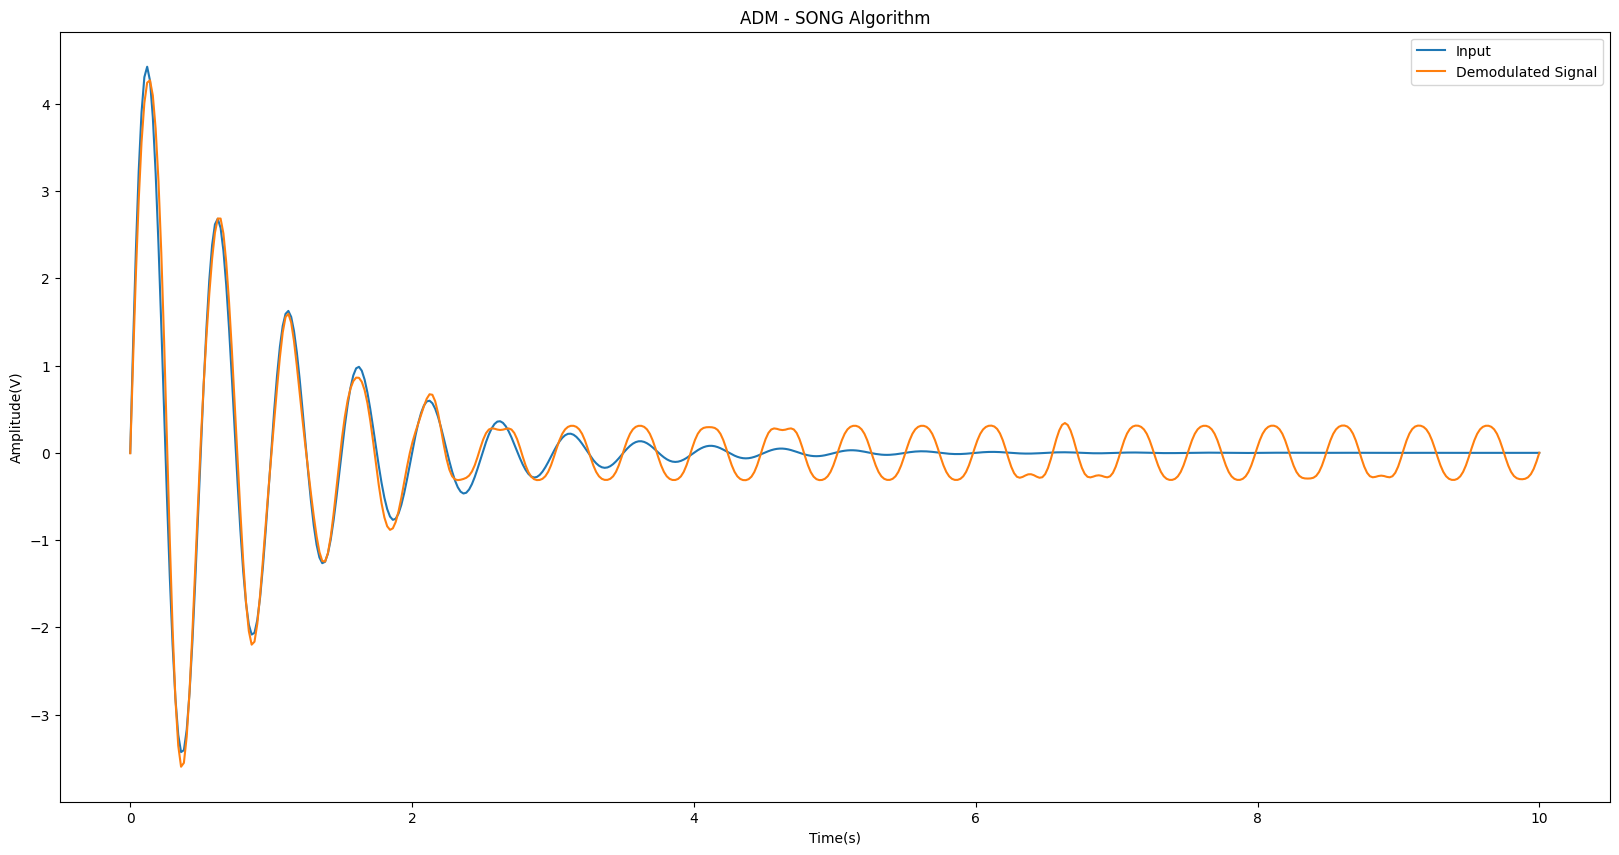

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

def delta_song(data, s0):
    # SONG Algorithm
    len_data = len(data)
    step_size = np.zeros(len_data)
    pred = np.zeros(len_data)
    e_hat = np.zeros(len_data)  # quantized error e_q(n)
    for i in range(1, len_data):
        # Current Error e(n)
        e_n = data[i] - pred[i - 1]
        # We are quantizing the error
        if e_n >= 0:
            e_hat[i] = 1
        else:
            e_hat[i] = -1
        # SONG Algorithm to change step size
        if e_hat[i] == e_hat[i - 1]: #if e_q(n) == e_q(n-1) we add a constant s0, else we subract s0 from step size (delta)
            step_size[i] = abs(step_size[i - 1]) + s0
        else:
            step_size[i] = abs(step_size[i - 1]) - s0
        # Accumulator
        pred[i] = pred[i - 1] + e_hat[i] * abs(step_size[i])
    # Encoded data : (0 for -1 and 1 for +1)
    encoded = e_hat >= 0
    return encoded, pred

def delta_song_demod(mod_data, s0, f, fs):
    # Demodulator for SONG Algorithm
    len_data = len(mod_data)
    x_dem = np.zeros(len_data)
    step_size = np.zeros(len_data)
    for i in range(1, len_data):
        # Encoded data to e_q(n) conversion
        if mod_data[i] == 0:
            e_hat = -1
        else:
            e_hat = 1
        # SONG Logic for step size
        if mod_data[i] == mod_data[i - 1]:
            step_size[i] = abs(step_size[i - 1]) + s0
        else:
            step_size[i] = abs(step_size[i - 1]) - s0
        x_dem[i] = e_hat * abs(step_size[i]) + x_dem[i - 1]

    # Reconstruction using Low pass filter
    fs = 1000 # Sampling rate (Hz)
    fc = 100 # Cutoff frequency (Hz)
    order = 4 # Filter order

    b, a = butter(order, fc / (fs / 2), 'low')
    demod = filtfilt(b, a, x_dem)
    return demod

def isnr(x, y):
    # Calculate Signal-to-Noise Ratio (SNR) in dB
    noise = x - y
    mse = np.mean(np.square(noise))
    return 10 * np.log10(np.mean(np.square(x))/mse)

# Sin*exp function
len_data = 500
t = np.linspace(0, 10, len_data)
Fs = 50
amp = 5
f = 2
x1 = amp * np.sin(2 * np.pi * f * t) * np.exp(-t)

s0 = 0.5
encoded, pred = delta_song(x1, s0)

# Demodulation
song_demod = delta_song_demod(encoded, s0, f, Fs)


dm_pred_snr1 = isnr(x1, pred)
dm_demod_mse1 = np.mean(np.square(x1 - song_demod))
print("SNR: ",dm_pred_snr1)
print("Mean Squared Error: ",dm_demod_mse1)

fig = plt.figure(figsize=(20, 10))
plt.plot(t, x1)
plt.step(t, pred)
plt.title('ADM - SONG Algorithm')
plt.xlabel('Time(s)')
plt.ylabel('Amplitude(V)')
plt.legend(['Input', 'SONG pred'])

fig1 = plt.figure(figsize=(20, 10))
plt.plot(t, x1)
plt.plot(t, song_demod)
plt.title('ADM - SONG Algorithm')
plt.xlabel('Time(s)')
plt.ylabel('Amplitude(V)')
plt.legend(['Input', 'Demodulated Signal'])
